<a href="https://colab.research.google.com/github/Sugirlstar/GPU_griddedCalcualtion_draft/blob/main/SPI_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculate the daily SPI (gamma distribution) across China
---

This is to calculate the daily SPI value based on ERA5-Land daily precipitation data.
* Based on the Google Colab GPU (A100), CPU RAM = around 80G; GPU RAM = around 40G
* input: nc file (around 8 G)
* output: zipped numpy array

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install netCDF4
!pip install xarray
# install cuda
!curl https://colab.chainer.org/install | sh -

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1553  100  1553    0     0   3448      0 --:--:-- --:--:-- --:--:--  3451
********************************************************************************
CUDA version could not be detected!
Try installing Chainer manually by: pip install chainer
********************************************************************************


In [2]:
import netCDF4 as nc
import numpy as np
import cupy as cp
from scipy.stats import gamma
import xarray as xr
import time

In [3]:
# set the nc file path in Google Drive
file_path = "/content/drive/MyDrive/Colab Notebooks/ERA5Land_precipitation_1970_2022_China_daily.nc"

# open the nc file
# dataset = nc.Dataset(file_path)
ds = xr.open_dataset(file_path)
numpy_data = ds['tp'].values
numpy_data = numpy_data.astype(np.float16)
numpy_data = numpy_data[1:,:,:] # delete 1969.12.31
del ds

cupy_data = cp.array(numpy_data)
del numpy_data


In [4]:
cupy_data.shape

(19358, 361, 641)

In [5]:
# create the date sequence
from datetime import datetime, timedelta
def generate_date_sequence(start_date_str, end_date_str, date_format="%Y%m%d"):

    start_date = datetime.strptime(start_date_str, date_format)
    end_date = datetime.strptime(end_date_str, date_format)

    date_sequence = []

    current_date = start_date

    # Iterate through the date range, adding each date to the sequence
    while current_date <= end_date:
        date_sequence.append(current_date.strftime(date_format))
        # add the date
        current_date +=timedelta(days=1)

    return date_sequence

def is_leap_year(year):
    """
    Determines whether a given year is a leap year
    """
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

def compute_dlist_from_sequence(date_sequence):
    """
    A function that generates a daylist from a sequence of dates
    """
    # Create a list of length 365 and initialize each element with an empty list
    dlist = [[] for _ in range(365)]

    for idx, date_str in enumerate(date_sequence):
        date_obj = datetime.strptime(date_str, "%Y%m%d")

        # Get the day of the year (1-366)
        day_of_year = date_obj.timetuple().tm_yday

        # For February 29, adjust to February 28
        if date_obj.month == 2 and date_obj.day == 29:
            dlist[58].append(idx)  # 58 is the position on February 28 in a non-leap year
        else:
            # Adjusted to leap years
            position = day_of_year - 1
            if day_of_year > 59 and is_leap_year(date_obj.year):
                position -= 1
            dlist[position].append(idx)

    return dlist


# Generate a date series
date_sequence = generate_date_sequence("19700101", "20221231")
# Generate a daylist based on a date series
daylist = compute_dlist_from_sequence(date_sequence)

In [6]:
# Compute the 90-day cumulative values for a 3D CuPy array
def compute_90_day_cumulative_cupy(data):
    """
    Compute the 90-day cumulative values for a 3D CuPy array.

    Args:
    - data (cp.ndarray): A 3D CuPy array with the shape (days, longitude, latitude).

    Returns:
    - cp.ndarray: A 3D CuPy array with the shape (days, longitude, latitude) containing the 90-day cumulative values.
    """

    result = []
    for i in range(89, data.shape[0]):
        # Sum the values from day t-89 to day t
        moving_sum = cp.nansum(data[i-89:i+1], axis=0)
        result.append(moving_sum)
        del moving_sum

    return cp.stack(result)

start_time_gpu = time.time()

# Compute the 90-day cumulative values for the data
cumulative_90_days_cupy = compute_90_day_cumulative_cupy(cupy_data)

# clean the pool
cp.get_default_memory_pool().free_all_blocks()

nan_array = cp.full((89, cumulative_90_days_cupy.shape[1], cumulative_90_days_cupy.shape[2]), cp.nan)

# create an empty array
cumulative_90_days_fill = cp.empty(cupy_data.shape, dtype=cp.float16)
cumulative_90_days_fill[:89,:,:] = nan_array
cumulative_90_days_fill[89:,:,:] = cumulative_90_days_cupy

#cumulative_90_days_fill = cp.vstack((nan_array, cumulative_90_days_cupy))

del cumulative_90_days_cupy
del nan_array
del cupy_data
# clean the pool
cp.get_default_memory_pool().free_all_blocks()

end_time_gpu = time.time()
gpu_time = end_time_gpu - start_time_gpu
print(gpu_time)

6.24256443977356


In [7]:
cp.get_default_memory_pool().free_all_blocks()
import gc
gc.collect()

9

In [8]:
import cupyx.scipy.special

start_time_gpu = time.time()

SPI_array = cp.empty(cumulative_90_days_fill.shape, dtype=cp.float16)

for days in daylist:
  A = cumulative_90_days_fill[days,:,:]
  # Check for NaNs in each grid point
  # nan_counts = cp.isnan(A).sum(axis=0)
  # valid_mask = nan_counts <= 90

  #Maximum likelihood estimation finds two parameters of the gamma distribution
  mean_values = cp.nanmean(A, axis=0)
  sum_log_values = cp.nansum(cp.log(A), axis=0)
  n = (~cp.isnan(A)).sum(axis=0)
  medA = cp.log(mean_values) - sum_log_values / n
  A_k = (1+ cp.sqrt(1+4*medA/3)) / (4*medA)
  A_scale = mean_values/A_k

  # Use broadcasting to extend the dimensions of k and scale to match the dimensions of A
  k_expanded = A_k[cp.newaxis,:,:]
  scale_expanded = A_scale[cp.newaxis,:,:]

  gamma_pdf = cupyx.scipy.special.gammainc(k_expanded,A/scale_expanded)
  indexValue = cupyx.scipy.special.ndtri(gamma_pdf)

  SPI_array[days,:,:] = indexValue


end_time_gpu = time.time()
gpu_time = end_time_gpu - start_time_gpu
print(gpu_time)

45.819023847579956


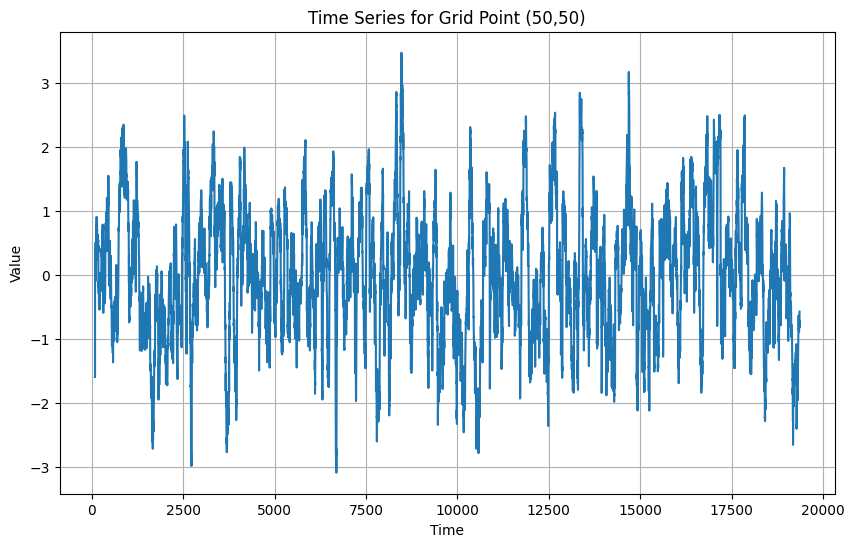

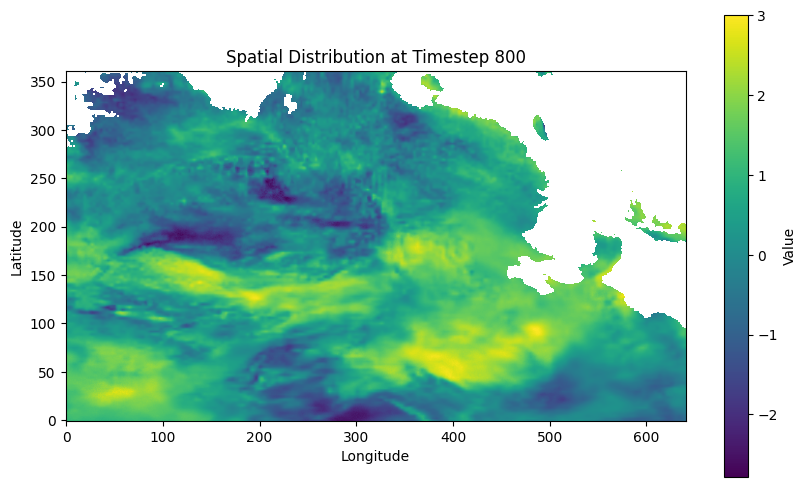

In [9]:
import matplotlib.pyplot as plt

def plot_time_series(new_A, x, y):
    # Extracts a time series for a given grid
    time_series = new_A[:, x, y]

    # plot
    plt.figure(figsize=(10,6))
    plt.plot(time_series)
    plt.title(f"Time Series for Grid Point ({x},{y})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def plot_spatial_distribution(new_A, t):
    # Extracts the spatial distribution at a given point in time
    spatial_data = new_A[t, :, :]

    # plot
    plt.figure(figsize=(10,6))
    plt.imshow(spatial_data, cmap='viridis', origin='lower')
    plt.colorbar(label="Value")
    plt.title(f"Spatial Distribution at Timestep {t}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


indexNP = cp.asnumpy(SPI_array)

# Select a grid / a time point to plot
plot_time_series(indexNP, 50, 50)
plot_spatial_distribution(indexNP, 800)
# notice: the map is inverse at the latitude

In [10]:
# Output the SPI result as a compressed np file
print(indexNP.shape)
print(len(date_sequence))
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/ERA5Land_SPI_China_19691231_20221231.npz', arr1=indexNP)


(19358, 361, 641)
19358
